In [1]:
import torch
import non_local_boxes
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import matplotlib.patches as mpatches

# Sugar coating for reloading
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Implementation of `rho(P)`

In [2]:
# def BG15_form(P): # P is a 4x4 box, in the usual form
#     P = non_local_boxes.utils.matrix_to_tensor(P)
#     Q = torch.zeros(4,4)
#     for i in range(4):
#         a, x = i//2, i%2
#         for j in range(4):
#             b, y = j//2, j%2
#             Q[i,j] = P[a, b, x, y]
#     return Q

# def BG15_form(P): # P is a 4x4 box, in the usual form
#     P = non_local_boxes.utils.matrix_to_tensor(P)
#     Q = torch.zeros(4,4)
#     for i in range(4):
#         a, x = i//2, i%2
#         for j in range(2):
#             # b, y = j, x
#             Q[i, 2*j + x] = P[a, j, x, x]*0.5
#     return Q

def KU11_form(P, x, y):  # P is a 4x4 box
    return torch.reshape(P[ 2*x+y, :], (2,2))  # the output is a 2x2 matrix

In [3]:
def marginals(Q):  # Q is a 2x2 matrix
    e = torch.ones(2)
    pX = torch.tensordot(Q, e, dims=1)
    pY = torch.tensordot(torch.t(Q), e, dims=1)
    return pX, pY

def marginals_diag(Q):  # Q is a 2x2 matrix
    pX, pY = marginals(Q)
    P_X, P_Y = torch.diag_embed(pX), torch.diag_embed(pY)
    return P_X, P_Y

In [4]:
def P_tilda(Q):  # Q is a 2x2 matrix
    pX, pY = marginals(Q)
    A, B = torch.diag_embed(torch.pow(pX, -0.5)), torch.diag_embed(torch.pow(pY, -0.5))
    return torch.tensordot(torch.tensordot(A, Q, dims=1), B, dims=1)

In [5]:
def rho(P):   # P is a 4x4 matrix, in the usual form
    sing_val = torch.zeros(2, 2)
    for x in range(2):
        for y in range(2):
            Q = KU11_form(P, x, y)
            sing_val[x,y] = torch.linalg.svdvals(P_tilda(Q))[1]
    return round(float(torch.max(sing_val)), 6)

# Compute $\rho$ of somes boxes

In [6]:
# import numpy as np
# import pylab as pl
# from matplotlib.colors import hsv_to_rgb

# V, H = np.mgrid[0:1:100j, 0:1:300j]
# S = np.ones_like(V)
# HSV = np.dstack((H,S,V))
# RGB = hsv_to_rgb(HSV)
# pl.imshow(RGB, origin="lower", extent=[0, 360, 0, 1], aspect=150)
# pl.xlabel("H")
# pl.ylabel("V")
# pl.title("$S_{HSV}=1$")
# pl.show()

In [7]:
PR = non_local_boxes.utils.PR
PRprime = non_local_boxes.utils.PRprime
SR = non_local_boxes.utils.SR
I = non_local_boxes.utils.I

In [8]:
p = 0.156
print(rho(PR), rho(SR), rho(I), rho((PR+I)/2))
print(rho(p*PR + (1-p)*I))

1.0 1.0 0.0 0.5
0.156


In [9]:
def draw_triangle(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size): # Box is a 4x4 tensor
    X = torch.tensor([[0, 10], [10,0], [0, 0]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            p = rho(alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3)
            color_point = hsv_to_rgb([p, 1, 1]) #(0., 0.*(1-p)+0.8*p, 0.*(1-p)+0.8*p)
            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)

    plt.text(X[0,0]+0.3, X[0,1], Box1_name, horizontalalignment='center')
    plt.text(X[1,0], X[1,1]+0.3, Box2_name, verticalalignment='center')
    plt.text(X[2,0], X[2,1]-0.3, Box3_name, verticalalignment='center')
    plt.title("Level lines of rho (the rho from [BG15])")
    color1 = mpatches.Patch(color=hsv_to_rgb([1, 1, 1]), label='rho = 1')
    color075 = mpatches.Patch(color=hsv_to_rgb([0.75, 1, 1]), label='rho = 0.75')
    color05 = mpatches.Patch(color=hsv_to_rgb([0.5, 1, 1]), label='rho = 0.5')
    color025 = mpatches.Patch(color=hsv_to_rgb([0.25, 1, 1]), label='rho = 0.25')
    plt.legend(handles=[color1, color075, color05, color025]) 
    plt.show()

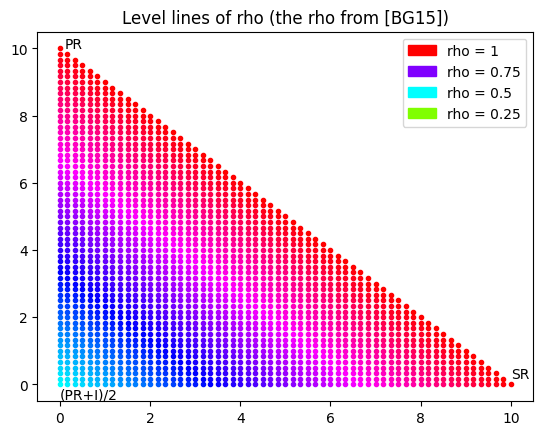

In [10]:
draw_triangle(
    Box1 = PR,
    Box1_name = "PR",
    Box2 = SR,
    Box2_name = "SR",
    Box3 = (PR+I)/2,
    Box3_name = "(PR+I)/2",
    box_grid_size = 60
)

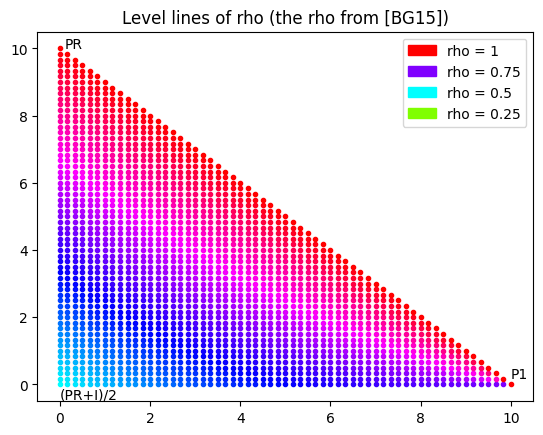

In [28]:
P0 = non_local_boxes.utils.P_0
P1 = non_local_boxes.utils.P_1

draw_triangle(
    Box1 = PR,
    Box1_name = "PR",
    Box2 = 0.9999*P1+0.00001*PR,
    Box2_name = "P1",
    Box3 = (PR+I)/2,
    Box3_name = "(PR+I)/2",
    box_grid_size = 60
)

In [29]:
rho(0.9999*P1+0.00001*PR)

1.0

# Draw above BBBLMTU

In [11]:
def draw_above_BBLMTU(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size): # Box is a 4x4 tensor
    X = torch.tensor([[0, 10], [10,0], [0, 0]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)
    a = (3 + float(torch.sqrt(torch.tensor(6))))/6
    threshold = rho(a*non_local_boxes.utils.PR + (1-a)*non_local_boxes.utils.PRbar)

    color_above_threshold = hsv_to_rgb([0.475, 1, 0.8])
    color_below_threshold = hsv_to_rgb([0.475, 1, 0.5])

    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            p = rho(alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3)
            color_point = color_below_threshold #(0., 0.3, 0.3)
            if p > threshold:
                color_point = color_above_threshold # (0., 0.7, 0.7)
            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)

    plt.text(X[0,0]+0.3, X[0,1], Box1_name, horizontalalignment='center')
    plt.text(X[1,0], X[1,1]+0.3, Box2_name, verticalalignment='center')
    plt.text(X[2,0], X[2,1]-0.3, Box3_name, verticalalignment='center')
    plt.title("[BG15] combined with [BBLMTU06]")
    color_below_patch = mpatches.Patch(color=color_below_threshold, label='Impossible to distill until the collapsing triangle.')
    color_above_patch = mpatches.Patch(color=color_above_threshold, label='No conclusion.')
    plt.legend(handles=[color_below_patch, color_above_patch])   
    plt.show()

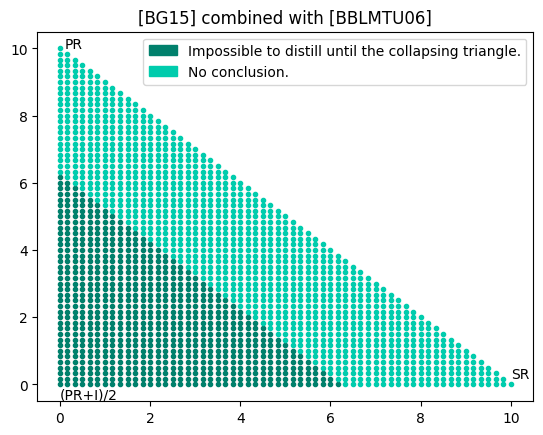

In [12]:
draw_above_BBLMTU(
    Box1 = PR,
    Box1_name = "PR",
    Box2 = SR,
    Box2_name = "SR",
    Box3 = (PR+I)/2,
    Box3_name = "(PR+I)/2",
    box_grid_size = 60
)

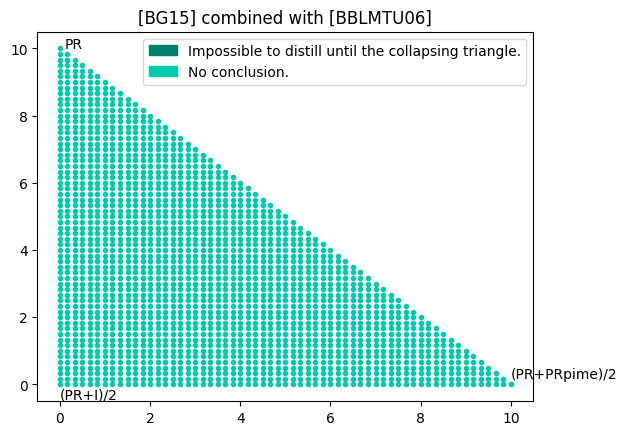

In [13]:
draw_above_BBLMTU(
    Box1 = PR,
    Box1_name = "PR",
    Box2 = SR,
    Box2_name = "(PR+PRpime)/2",
    Box3 = (PR+PRprime)/2,
    Box3_name = "(PR+I)/2",
    box_grid_size = 60
)

# $\rho$ average

In [14]:
def rho_average(P):   # P is a 4x4 matrix, in the usual form
    sing_val = torch.zeros(2, 2)
    for x in range(2):
        for y in range(2):
            Q = KU11_form(P, x, y)
            sing_val[x,y] = torch.linalg.svdvals(P_tilda(Q))[1]
    return round(float(torch.sum(sing_val)/4), 6)

In [15]:
rho_average(PR), rho_average(SR), rho_average(I), rho_average((PR+SR)/2)

(1.0, 1.0, 0.0, 0.75)

In [16]:
def draw_triangle_average(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size): # Box is a 4x4 tensor
    X = torch.tensor([[0, 10], [10,0], [0, 0]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            p = rho_average(alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3)
            color_point = hsv_to_rgb([p, 1, 1]) # ((1-p)*0., 0.*(1-p)+0.8*p, 0.*(1-p)+0.8*p)
            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)

    plt.text(X[0,0]+0.3, X[0,1], Box1_name, horizontalalignment='center')
    plt.text(X[1,0], X[1,1]+0.3, Box2_name, verticalalignment='center')
    plt.text(X[2,0], X[2,1]-0.3, Box3_name, verticalalignment='center')
    plt.title("Level lines of `rho_average`")
    color1 = mpatches.Patch(color=hsv_to_rgb([1, 1, 1]), label='rho_average = 1')
    color075 = mpatches.Patch(color=hsv_to_rgb([0.75, 1, 1]), label='rho_average = 0.75')
    color05 = mpatches.Patch(color=hsv_to_rgb([0.5, 1, 1]), label='rho_average = 0.5')
    color025 = mpatches.Patch(color=hsv_to_rgb([0.25, 1, 1]), label='rho_average = 0.25')
    plt.legend(handles=[color1, color075, color05, color025]) 
    plt.show()

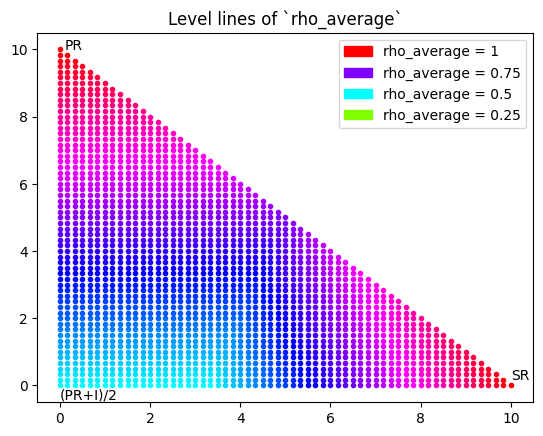

In [17]:
draw_triangle_average(
    Box1 = PR,
    Box1_name = "PR",
    Box2 = SR,
    Box2_name = "SR",
    Box3 = (PR+I)/2,
    Box3_name = "(PR+I)/2",
    box_grid_size = 60
)

In [18]:
def draw_above_BBLMTU_average(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size): # Box is a 4x4 tensor
    X = torch.tensor([[0, 10], [10,0], [0, 0]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)
    a = (3 + float(torch.sqrt(torch.tensor(6))))/6
    threshold = rho_average(a*non_local_boxes.utils.PR + (1-a)*non_local_boxes.utils.PRbar)

    color_above_threshold = hsv_to_rgb([0.475, 1, 0.8])
    color_below_threshold = hsv_to_rgb([0.475, 1, 0.5])

    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            p = rho_average(alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3)
            color_point = color_below_threshold # (0., 0.3, 0.3)
            if p > threshold:
                color_point = color_above_threshold # (0., 0.7, 0.7)
            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)

    plt.text(X[0,0]+0.3, X[0,1], Box1_name, horizontalalignment='center')
    plt.text(X[1,0], X[1,1]+0.3, Box2_name, verticalalignment='center')
    plt.text(X[2,0], X[2,1]-0.3, Box3_name, verticalalignment='center')
    plt.title("`rho_average` combined with [BBLMTU06]")
    color_below_patch = mpatches.Patch(color=color_below_threshold, label='Impossible to distill until the collapsing triangle.')
    color_above_patch = mpatches.Patch(color=color_above_threshold, label='No conclusion.')
    plt.legend(handles=[color_below_patch, color_above_patch])   
    plt.show()

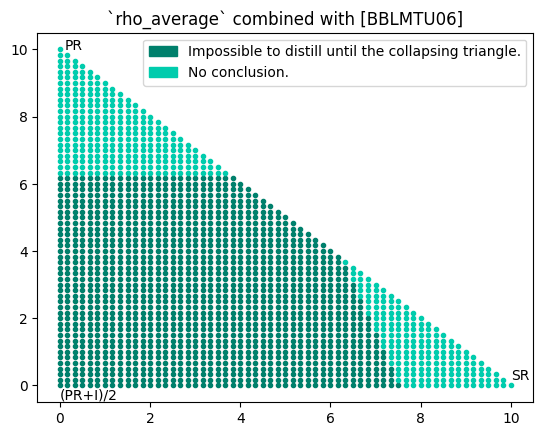

In [19]:
draw_above_BBLMTU_average(
    Box1 = PR,
    Box1_name = "PR",
    Box2 = SR,
    Box2_name = "SR",
    Box3 = (PR+I)/2,
    Box3_name = "(PR+I)/2",
    box_grid_size = 60
)

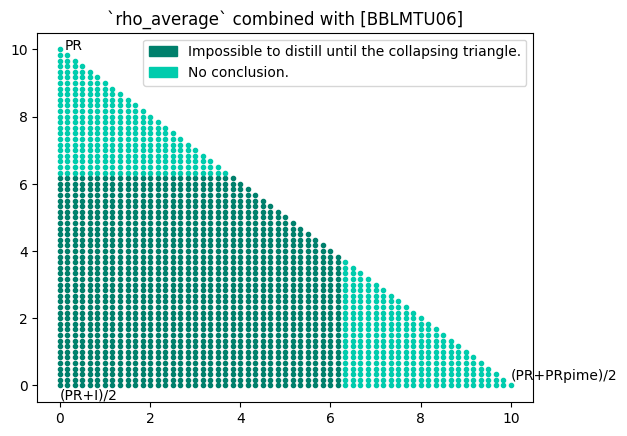

In [20]:
draw_above_BBLMTU_average(
    Box1 = PR,
    Box1_name = "PR",
    Box2 = SR,
    Box2_name = "(PR+PRpime)/2",
    Box3 = (PR+PRprime)/2,
    Box3_name = "(PR+I)/2",
    box_grid_size = 60
)